<a href="https://colab.research.google.com/github/nusratsuma45/Age_Prediction/blob/main/Resnet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Number of training samples: 4098
Number of validation samples: 1023
94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/50
129/129 [==============================] - ETA: 0s - loss: 1.6964 - accuracy: 0.3285 
Epoch 1: val_loss improved from inf to 1.87346, saving model to best_model_resnet50.keras
129/129 [==============================] - 2355s 18s/step - loss: 1.6964 - accuracy: 0.3285 - val_loss: 1.8735 - val_accuracy: 0.3050 - lr: 1.0000e-04
Epoch 2/50
129/129 [==============================] - ETA: 0s - loss: 1.5304 - accuracy: 0.3851
Epoch 2: val_loss improved from 1.87346 to 1.36890, saving model to best_model_resnet50.keras
129/129 [==============================] - 100s 778ms/step - loss: 1.5304 - accuracy: 0.3851 - val_loss: 1.3689 - val_accuracy: 0.4311 - lr: 1.0000e-04
Epoch 3/50
129/129 [==============================] - ETA: 0s

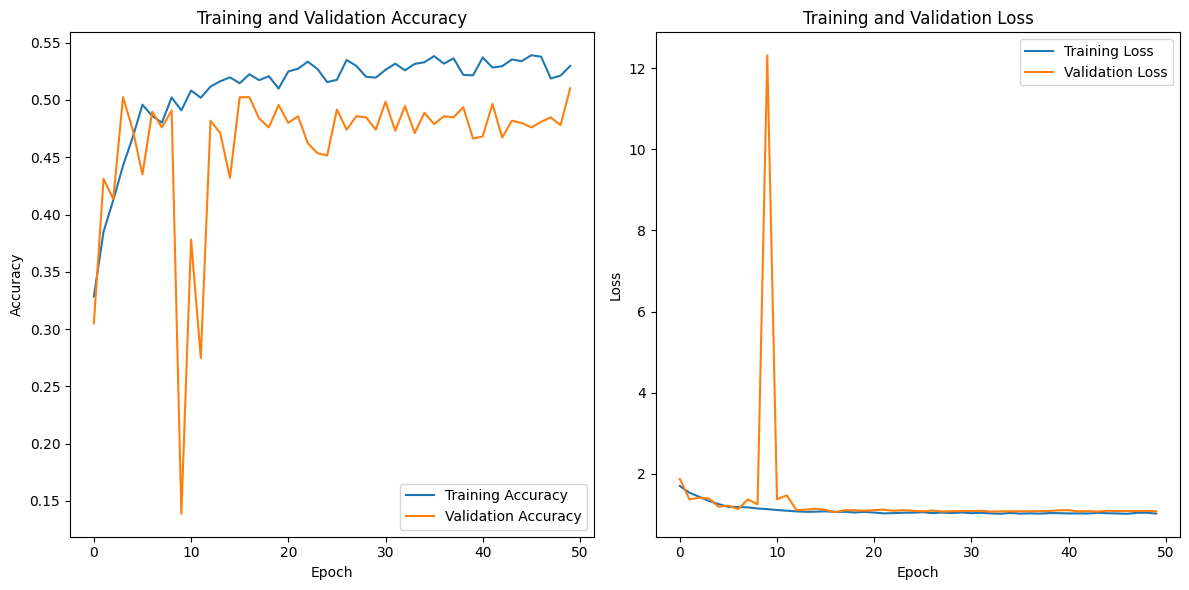

40/40 [==============================] - 830s 21s/step - loss: 0.9915 - accuracy: 0.5364
Test Accuracy: 53.64%
Test Loss: 0.9915
40/40 [==============================] - 7s 141ms/step


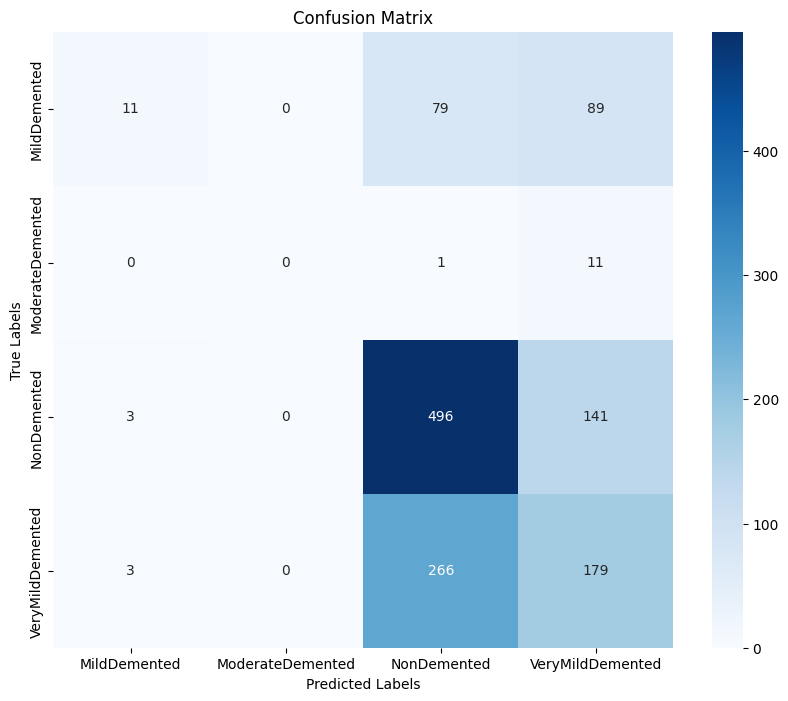

Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.65      0.06      0.11       179
ModerateDemented       0.00      0.00      0.00        12
     NonDemented       0.59      0.78      0.67       640
VeryMildDemented       0.43      0.40      0.41       448

        accuracy                           0.54      1279
       macro avg       0.42      0.31      0.30      1279
    weighted avg       0.53      0.54      0.50      1279



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [2]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

# Set the paths to the dataset directories
data_path = "/content/drive/MyDrive/Alzheimer/AlzheimerDataset/train"
test_path = "/content/drive/MyDrive/Alzheimer/AlzheimerDataset/test"

# Use the Image Data Generator to import the images from the dataset with a validation split
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=[0.8, 1.2],
                                   validation_split=0.2)  # 20% for validation

# Train generator for training data
train_generator = train_datagen.flow_from_directory(data_path,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='sparse',
                                                    subset='training')  # Use subset for training

# Validation generator for validation data
valid_generator = train_datagen.flow_from_directory(data_path,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='sparse',
                                                    subset='validation')  # Use subset for validation

# Test generator for test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode='sparse',
                                                  shuffle=False)

# Print the number of samples in training and validation sets
print(f"Number of training samples: {train_generator.samples}")
print(f"Number of validation samples: {valid_generator.samples}")

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the initial layers in the base model
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Create a new model on top of the pre-trained base model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())  # Add batch normalization
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # Adjust the number of output classes as per your dataset

# Compile the model
optimizer = Adam(learning_rate=0.0001)  # Specify learning rate this way
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set up callbacks
model_checkpoint = ModelCheckpoint('best_model_resnet50.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50,
    callbacks=[model_checkpoint, reduce_lr]
)

# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Get the ground truth labels and predictions
test_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Compute the classification report
report = classification_report(test_labels, predicted_labels, target_names=test_generator.class_indices.keys())
print('Classification Report:')
print(report)
